## Libraries

In [2]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from itertools import groupby
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import requests
import json
import time
import re


/Users/rayenebech/Desktop/rayene/ytu/spring_2022/Hesaplamali Anabilim/HW/HW_2/codes/hw2_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tqdm.pandas()

# Preprocess

In [3]:
HTML_PATTERN = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});' )
URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
USERNAME_PATTERN = re.compile(r'([@][A-Za-z0-9_]+)|(\w+:\/\/\S+)')


In [4]:
def clean_text(text):
     text = re.sub(HTML_PATTERN, '', text)
     text = re.sub(URL_PATTERN, '', text)
     text = re.sub(USERNAME_PATTERN, '', text)
     return " ".join([k for k,v in groupby(text.split())]) # Remove Repetitive Words

In [5]:
def sample_equally(number_of_samples, category_column, df):
    all_dfs = []
    labels = df[category_column].unique()
    for label in labels:
        df_ = df[df[category_column] ==label]
        df_sampled = df_.sample(n= number_of_samples, ignore_index = True)
        all_dfs.append(df_sampled)
    df = pd.concat(all_dfs)
    df = df.sample(frac=1)
    return df

## Datasets

In [6]:
# Datasets are taken from: https://github.com/yinwenpeng/BenchmarkingZeroShot
topic_dataset = pd.read_csv("datasets/topic/test.txt", sep="\t", names= ["topic_label", "text"])
emotion_dataset = pd.read_csv("datasets/emotion/test.txt", sep="\t", names= ["sentiment", "source", "text"])

#Remove texts with no emotion (noemo) from the dataset
emotion_dataset = emotion_dataset[emotion_dataset["sentiment"]!= "noemo"]
emotion_labels = list(emotion_dataset["sentiment"].unique())
# Add class names to the topics dataset
with open("datasets/topic/classes.txt", "r")  as f:
    topic_classes = f.readlines()
topic_classes = [topic.strip("\n") for topic in topic_classes]
topic_dataset["topic_name"] = topic_dataset["topic_label"].apply(lambda x: topic_classes[x])


In [7]:
# Sample from the datasets
topic_dataset_sampled = sample_equally(100, "topic_name",topic_dataset)
emotion_dataset_sampled = sample_equally(100, "sentiment",emotion_dataset)
print("************** Topic Classification Dataset **************")
print(topic_dataset_sampled["topic_name"].value_counts())
print("************** Sentiment Analysis Dataset **************")
print(emotion_dataset_sampled["sentiment"].value_counts())

************** Topic Classification Dataset **************
topic_name
Computers & Internet      100
Education & Reference     100
Society & Culture         100
Health                    100
Science & Mathematics     100
Business & Finance        100
Politics & Government     100
Sports                    100
Entertainment & Music     100
Family & Relationships    100
Name: count, dtype: int64
************** Sentiment Analysis Dataset **************
sentiment
anger       100
surprise    100
disgust     100
love        100
guilt       100
sadness     100
fear        100
joy         100
shame       100
Name: count, dtype: int64


In [8]:
#Clean datasets
topic_dataset_sampled["text"] = topic_dataset_sampled["text"].apply(lambda x: clean_text(x))
emotion_dataset_sampled["text"] = emotion_dataset_sampled["text"].apply(lambda x: clean_text(x))

In [9]:
#topic_dataset_sampled.to_csv("topic_dataset_sampled.csv", index = False)
#emotion_dataset_sampled.to_csv("emotion_dataset_sampled.csv", index= False)

In [3]:
topic_dataset_sampled = pd.read_csv("topic_dataset_sampled.csv")
emotion_dataset_sampled= pd.read_csv("emotion_dataset_sampled.csv")

In [10]:
emotion_dataset_sampled[emotion_dataset_sampled["sentiment"]== "disgust"]["text"].values.tolist()

['During the week-end at home, my mother fries greasy and unhealthy meat dishes which make me feel sick.',
 'At a party I met a girl who drew me to her, told me some nonsense and always wanted to kiss me.',
 'On TV I saw a report about church in Amerika. A priest was shown who was performing miracles in front of the camera - I felt disgusted.',
 'In a certain book I read about cruelties and violence in prison and souteneur circles; I felt especially disgusted when I read detailed descriptions of physical and mental torture of less powerful people.',
 'i think that studying has really started taking its toll..',
 'When I have seen people very drunk and making fools of themselves.',
 'I stayed for several weeks with a friend of mine before she moved to live with her husband. One evening he came drunk and made an awful scene, which I still remember.',
 'While travelling in a bus, there were three people sitting behind me (two men and a woman). They were drunk and the conversation was unbe

<Axes: >

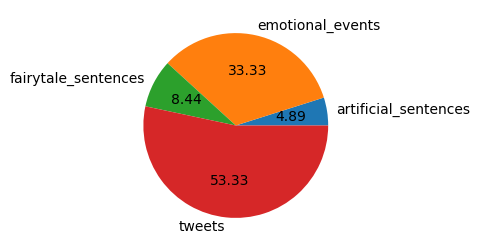

In [112]:
emotion_dataset_sampled.groupby('source').size().plot(kind='pie', autopct='%.2f', figsize=(3,3) )


# Plot functions

In [52]:
def get_confusion_matrix(df,labels, y_true_column, y_pred_column):
    cm = confusion_matrix(df[y_true_column].values.tolist(), df[y_pred_column].values.tolist(), labels=labels)
    cm_df = pd.DataFrame(cm,index = labels, columns = labels)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title(f'Confusion Matrix for prompt: {y_pred_column}')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

# Build vocab 

In [15]:
headers = {
	"X-RapidAPI-Key": "889e39cb31mshf8da442df2edcefp178fdcjsn5f006f6fc897",
	"X-RapidAPI-Host": "wordsapiv1.p.rapidapi.com"
}

def get_vocab(word,endpoint):
    url = f"https://wordsapiv1.p.rapidapi.com/words/{word}/{endpoint}"
    response = requests.request("GET", url, headers=headers)
    return response.json()

In [16]:
CLASS_CATEGORIES = {
    "family and relationships": list(set(get_vocab("family","hasMembers")["hasMembers"] + get_vocab("relationships","hasTypes")["hasTypes"] )),
    "politics and government ": list(set(get_vocab("politics","hasCategories")["hasCategories"] + get_vocab("government","hasCategories")["hasCategories"] )),
    "business and finance": list(set(get_vocab("business","hasCategories")["hasCategories"] + get_vocab("finance","hasCategories")["hasCategories"] )), 
    "education and reference": list(set(get_vocab("education","hasTypes")["hasTypes"] + get_vocab("reference","hasTypes")["hasTypes"] )),   
    "society and culture": list(set(get_vocab("society","hasTypes")["hasTypes"] + get_vocab("culture","hasTypes")["hasTypes"] )),       
    "entertainment and music": list(set(get_vocab("entertainment","hasTypes")["hasTypes"] + get_vocab("music","hasCategories")["hasCategories"] )),      
    "science and mathematics":list(set(get_vocab("science","hasTypes")["hasTypes"] + get_vocab("mathematics","hasTypes")["hasTypes"] )),      
    "sports": list(set(get_vocab("sport","hasCategories")["hasCategories"])),                     
    "computers and internet": list(set(get_vocab("computer","hasCategories")["hasCategories"] + get_vocab("internet","hasCategories")["hasCategories"] )),      
    "health": list(set(get_vocab("health","typeOf")["typeOf"])),                    

    "joy": list(set(get_vocab("joy","hasTypes")["hasTypes"])),         
    "fear" : list(set(get_vocab("fear","hasTypes")["hasTypes"])),       
    "sadness" : list(set(get_vocab("sadness","hasTypes")["hasTypes"])),    
    "love": list(set(get_vocab("love","hasTypes")["hasTypes"])),        
    "anger": list(set(get_vocab("anger","hasTypes")["hasTypes"])),         
    "shame":list(set(get_vocab("shame","hasTypes")["hasTypes"])),       
    "guilt": list(set(get_vocab("guilt","hasTypes")["hasTypes"])),       
    "disgust": list(set(get_vocab("disgust","hasTypes")["hasTypes"])),    
    "surprise" : list(set(get_vocab("surprise","hasTypes")["hasTypes"])),  
    }

In [239]:
with open("class_categories.json", "w") as fp:
    json.dump(CLASS_CATEGORIES,fp)

In [32]:
with open("custom_class_categories.json", "r") as fp:
    CLASS_CATEGORIES = json.load(fp)

# Prompt Design

In [33]:
CLASS_KEYWORDS = {
    "family and relationships": ", ".join(CLASS_CATEGORIES["family and relationships"]),
    "politics and government":  ", ".join(CLASS_CATEGORIES["politics and government"]),
    "business and finance": ", ".join(CLASS_CATEGORIES["business and finance"]),   
    "education and reference":  ", ".join(CLASS_CATEGORIES["education and reference"]),  
    "society and culture":  ", ".join(CLASS_CATEGORIES["society and culture"]),        
    "entertainment and music":  ", ".join(CLASS_CATEGORIES["entertainment and music"]),     
    "science and mathematics":  ", ".join(CLASS_CATEGORIES["science and mathematics"]),    
    "sports":  ", ".join(CLASS_CATEGORIES["sports"]),                   
    "computers and internet":  ", ".join(CLASS_CATEGORIES["computers and internet"]),    
    "health": ", ".join(CLASS_CATEGORIES["health"]),                 

    "joy": ", ".join(CLASS_CATEGORIES["joy"]),       
    "fear" : ", ".join(CLASS_CATEGORIES["fear"]),             
    "sadness" : ", ".join(CLASS_CATEGORIES["sadness"]),          
    "love": ", ".join(CLASS_CATEGORIES["love"]),              
    "anger": ", ".join(CLASS_CATEGORIES["anger"]),             
    "shame": ", ".join(CLASS_CATEGORIES["shame"]),            
    "guilt": ", ".join(CLASS_CATEGORIES["guilt"]),             
    "disgust": ", ".join(CLASS_CATEGORIES["disgust"]),          
    "surprise" : ", ".join(CLASS_CATEGORIES["surprise"]),         
    }

In [44]:
THIS_IS_I_FEEL = {
    "joy": "This is good! I am feeling happy",         
    "fear" : "This is bad! I am feeling afraid",        
    "sadness" : "This is bad! I am feeling sad",    
    "anger": "This is bad! I am feeling angry",           
    "shame": "This is bad! I am feeling ashamed",    
    "guilt": "This is bad! I am feeling guilty",       
    "disgust": "This is bad! I am feeling disgusted",  
    "love":   "I love it and I am feeling loved",             
    "surprise" : "This is surprising! I am feeling stunned",       
}
I_FEEL = {
    "joy": "I am feeling happy",         
    "fear" : "I am feeling afraid",        
    "sadness" : "I am feeling sad",    
    "anger": "I am feeling angry",           
    "shame": "I am feeling ashamed",    
    "guilt": "I am feeling guilty",       
    "disgust": "I am feeling disgusted",  
    "love":   "I am feeling loved",             
    "surprise" : "I am feeling stunned",  
}
# dictionary.cambridge.org
TOPIC_DEFINITION = {
    "family and relationships": "Family is a group of people who are related to each other, such as a mother, a father, and their children. Relationship is the way in which two things are connected.",
    "politics and government": "Politics is the activities of the government, members of law-making organizations, or people who try to influence the way a country is governed. The government is the group of people who officially control a country.",
    "business and finance":  "Business is the activity of buying and selling goods and services. Finance is the management of a supply of money.",
    "education and reference": "Education is the process of teaching or learning, especially in a school or college, or the knowledge that you get from this. Reference is a mention of something.", 
    "society and culture":  "Society is a large group of people who live together in an organized way, making decisions about how to do things and sharing the work that needs to be done. All the people in a country, or in several similar countries, can be referred to as a society. Culture is the way of life, especially the general customs and beliefs, of a particular group of people at a particular time.",        
    "entertainment and music":  "Entertainment is shows, films, television, or other performances or activities that entertain people, or a performance of this type. Music is a pattern of sounds made by musical instruments, voices, or computers, or a combination of these, intended to give pleasure to people listening to it.",  
    "science and mathematics":   "Science is knowledge from the careful study of the structure and behaviour of the physical world, especially by watching, measuring, and doing experiments, and the development of theories to describe the results of these activities. Mathematics is the study of numbers, shapes, and space using reason and usually a special system of symbols and rules for organizing them.",
    "sports": "Sport is a game, competition, or activity needing physical effort and skill that is played or done according to rules, for enjoyment and/or as a job.",                
    "computers and internet":  "Computer is an electronic machine that is used for storing, organizing, and finding words, numbers, and pictures, for doing calculations, and for controlling other machines. Internet is the large system of connected computers around the world that allows people to share information and communicate with each other.",  
    "health": "Health is the condition of the body and the degree to which it is free from illness, or the state of being well."
}

In [50]:
""" Prompt templates for topic classification dataset"""
def prompt_from_class_name(class_name, method):
    class_name = class_name.lower().strip().replace("&", "and")
    if method == "TEXT_IS_ABOUT":
        return f"This sentence is about {class_name}"
    elif method == "CLASS_NAME":
        return class_name
    elif method == "THIS_IS_I_FEEL":
        return THIS_IS_I_FEEL[class_name]
    elif method == "I_FEEL":
        return I_FEEL[class_name]
    elif method == "KEYWORDS": 
        return f"This sentence is about {CLASS_KEYWORDS[class_name]}" 
    elif method == "TOPIC_DEFINITION":
        return TOPIC_DEFINITION[class_name]
    elif method == "NEWS_ABOUT":
        return f"News article about {CLASS_KEYWORDS[class_name]}"

# Similarity Functions

In [17]:
def predict(model, text, classes, prompt_template):
    text_embedding = model.encode(text, convert_to_tensor=True)
    max_score = -1
    max_score_class = None
    for class_name in classes:
        prompt = prompt_from_class_name(class_name, prompt_template)
        prompt_embedding =  model.encode(prompt, convert_to_tensor=True)
        cosine_scores = util.cos_sim(text_embedding, prompt_embedding)[0][0]
        if max_score < cosine_scores:
            max_score = cosine_scores
            max_score_class = class_name
    return max_score_class



# BERT Model

In [41]:
bert_model = "bert-base-uncased"
bert_base_model = SentenceTransformer(bert_model)



No sentence-transformers model found with name /Users/rayenebech/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/rayenebech/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificat

In [42]:
model_name = bert_model.replace("/", "_").replace("-", "_")

## Topics Classification Dataset

In [46]:
prompts = ["TEXT_IS_ABOUT", "CLASS_NAME", "KEYWORDS", "TOPIC_DEFINITION", "NEWS_ABOUT"]
for prompt in prompts: 
    start = time.time()
    topic_dataset_sampled[prompt] = topic_dataset_sampled["text"].progress_apply(lambda x: predict(bert_base_model, x, topic_classes, prompt))
    duration  = time.time() - start
    avg_precision, avg_recall, avg_fscore, support = precision_recall_fscore_support(topic_dataset_sampled["topic_name"].values.tolist(), topic_dataset_sampled[prompt].values.tolist(), average='macro')
    # To check 
    per_class_percision, per_class_recall, per_class_fscore, per_class_support = precision_recall_fscore_support(topic_dataset_sampled["topic_name"].values.tolist(), topic_dataset_sampled[prompt].values.tolist(), average= None)
    with open(f"{model_name}_topic_dataset_sampled_results.json", "a") as fp:
        json.dump({
            "running time": duration,
            "prompt_type": prompt,
            "avg_precision": avg_precision,
            "avg_recall": avg_recall,
            "avg_fscore": avg_fscore,
            "per_class_percision": per_class_percision.tolist(),
            "per_class_recall": per_class_recall.tolist(),
            "per_class_fscore": per_class_fscore.tolist(),
        }, fp)

    

100%|██████████| 1000/1000 [09:15<00:00,  1.80it/s]
/Users/rayenebech/Desktop/rayene/ytu/spring_2022/Hesaplamali Anabilim/HW/HW_2/codes/hw2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rayenebech/Desktop/rayene/ytu/spring_2022/Hesaplamali Anabilim/HW/HW_2/codes/hw2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 1000/1000 [09:23<00:00,  1.77it/s]
/Users/rayenebech/Desktop/rayene/ytu/spring_2022/Hesaplamali Anabilim/HW/HW_2/codes/hw2_env/lib/python3.8/site-p

In [53]:
topic_dataset_sampled

,topic_label,text,topic_name,TEXT_IS_ABOUT,CLASS_NAME,KEYWORDS,TOPIC_DEFINITION,NEWS_ABOUT
0,4,what is RSS ? RSS is a format for syndicating ...,Computers & Internet,Computers & Internet,Family & Relationships,Computers & Internet,Computers & Internet,Computers & Internet
1,3,Who was the black inventor W.H . Richardson an...,Education & Reference,Society & Culture,Family & Relationships,Society & Culture,Science & Mathematics,Society & Culture
2,0,Prostitution and class c drugs . Should govern...,Society & Culture,Society & Culture,Family & Relationships,Society & Culture,Politics & Government,Society & Culture
3,4,what is the difference between JDBC and ODBC ?...,Computers & Internet,Computers & Internet,Family & Relationships,Computers & Internet,Computers & Internet,Computers & Internet
4,2,only for women : have you lifted a man ? What ...,Health,Computers & Internet,Family & Relationships,Sports,Society & Culture,Sports
...,...,...,...,...,...,...,...,...
995,3,Where can I find a spanish language executive ...,Education & Reference,Computers & Internet,Family & Relationships,Education & Reference,Education & Reference,Education & Reference
996,7,When is the most recent Harry Potter Movie com...,Entertainment & Music,Politics & Government,Family & Relationships,Sports,Society & Culture,Sports
997,8,"OK I 'm 18 , so why do 14 yr old girls think I...",Family & Relationships,Politics & Government,Family & Relationships,Society & Culture,Politics & Government,Society & Culture
998,3,How can I find out if credits from a class tak...,Education & Reference,Computers & Internet,Business & Finance,Education & Reference,Education & Reference,Education & Reference


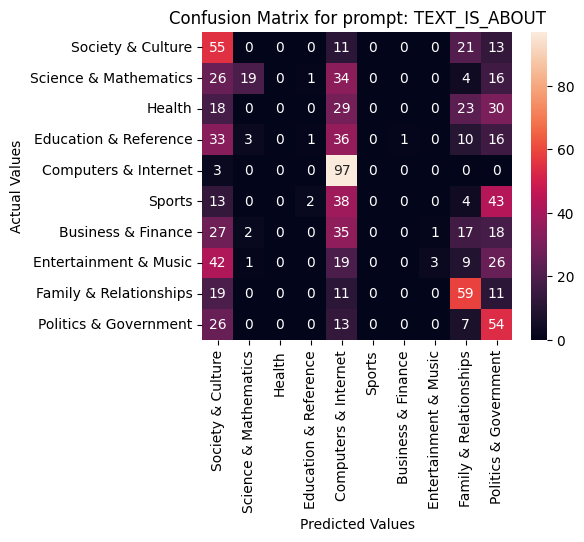

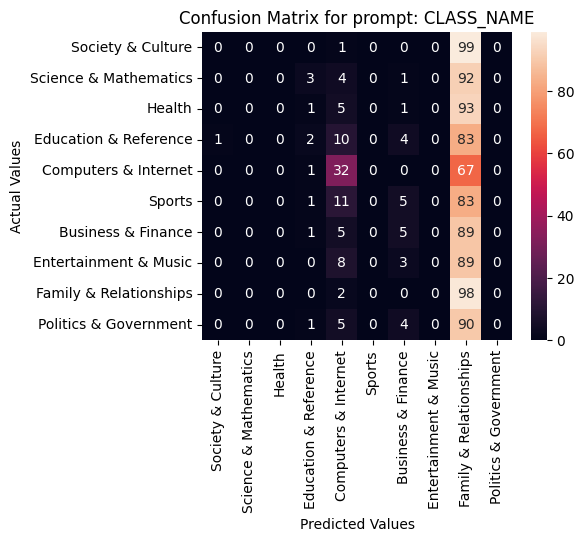

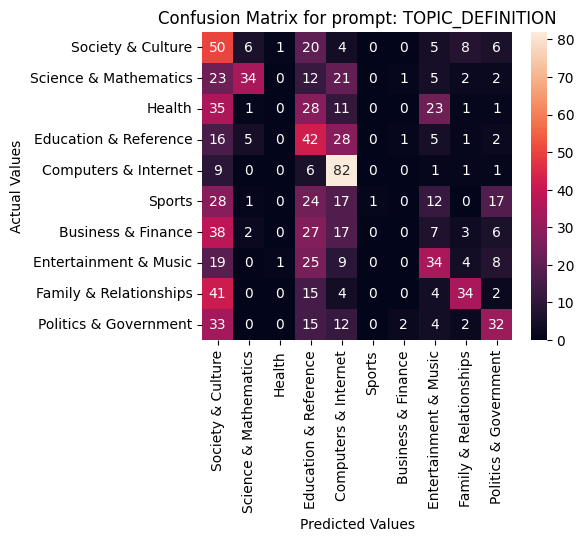

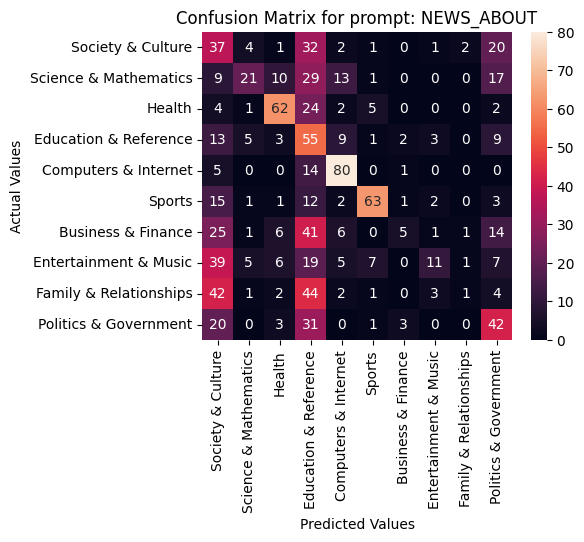

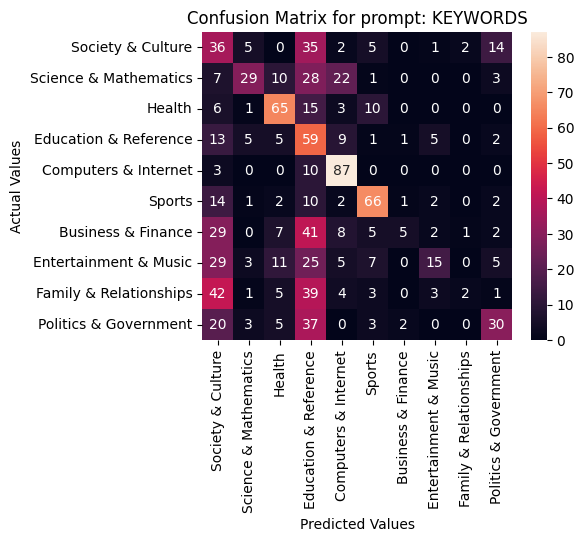

In [54]:
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "TEXT_IS_ABOUT")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "CLASS_NAME")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "TOPIC_DEFINITION")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "NEWS_ABOUT")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "KEYWORDS")

In [55]:
topic_dataset_sampled.to_csv(f"{model_name}topic_dataset_sampled_results.csv", index= False)

## Sentiment Analysis Dataset

In [24]:
prompts = ["TEXT_IS_ABOUT", "CLASS_NAME", "THIS_IS_I_FEEL", "I_FEEL", "KEYWORDS"]
labels =list(emotion_dataset_sampled["sentiment"].unique())
for prompt in prompts: 
    start = time.time()
    emotion_dataset_sampled[prompt] = emotion_dataset_sampled["text"].progress_apply(lambda x: predict(bert_base_model, x,labels, prompt))
    duration  = time.time() - start
    avg_precision, avg_recall, avg_fscore, support = precision_recall_fscore_support(emotion_dataset_sampled["sentiment"].values.tolist(), emotion_dataset_sampled[prompt].values.tolist(), average='macro')
    # To check 
    per_class_percision, per_class_recall, per_class_fscore, per_class_support = precision_recall_fscore_support(emotion_dataset_sampled["sentiment"].values.tolist(), emotion_dataset_sampled[prompt].values.tolist(), average= None)
    with open(f"{model_name}_emotion_dataset_sampled_results.json", "a") as fp:
        json.dump({
            "running time": duration,
            "prompt_type": prompt,
            "avg_precision": avg_precision,
            "avg_recall": avg_recall,
            "avg_fscore": avg_fscore,
            "per_class_percision": per_class_percision.tolist(),
            "per_class_recall": per_class_recall.tolist(),
            "per_class_fscore": per_class_fscore.tolist(),
        }, fp)

100%|██████████| 900/900 [05:26<00:00,  2.76it/s]
/Users/rayenebech/Desktop/rayene/ytu/spring_2022/Hesaplamali Anabilim/HW/HW_2/codes/hw2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rayenebech/Desktop/rayene/ytu/spring_2022/Hesaplamali Anabilim/HW/HW_2/codes/hw2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 900/900 [05:58<00:00,  2.51it/s]


In [25]:
emotion_dataset_sampled.to_csv(f"{model_name}_emotion_dataset_sampled_results.csv", index= False)

In [74]:
emotion_dataset_sampled = pd.read_csv(f"bert_base_uncased_emotion_dataset_sampled_results.csv")

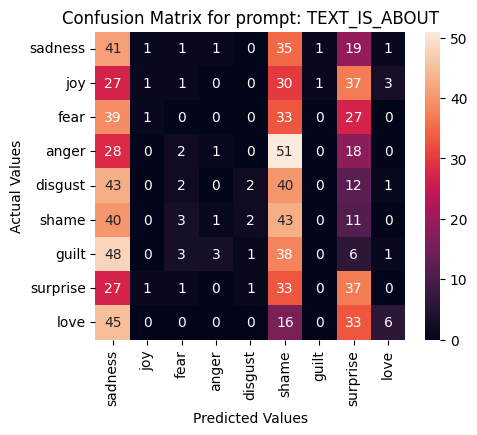

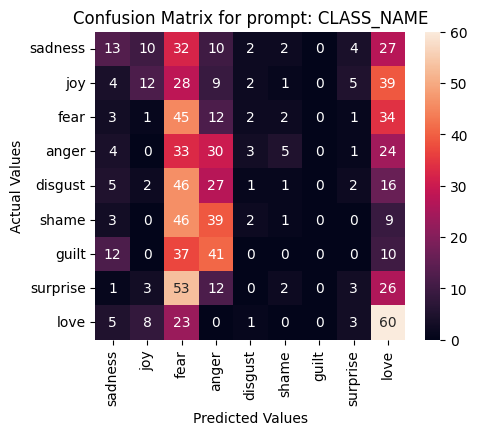

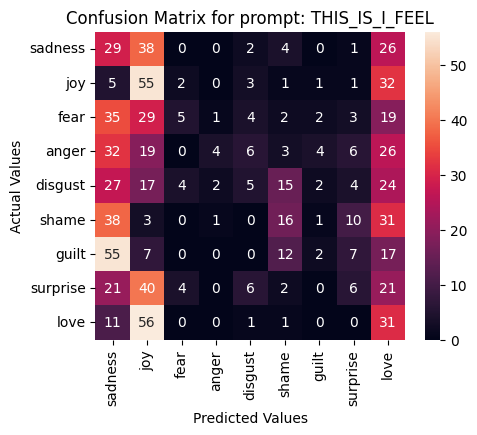

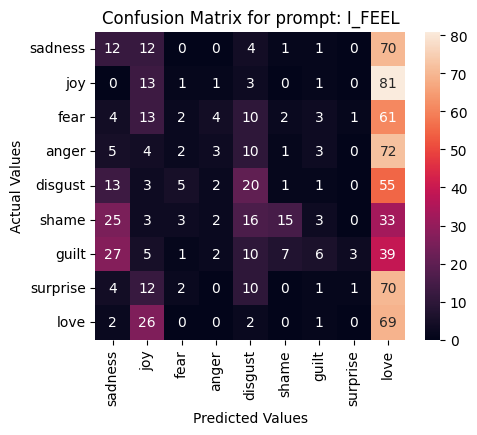

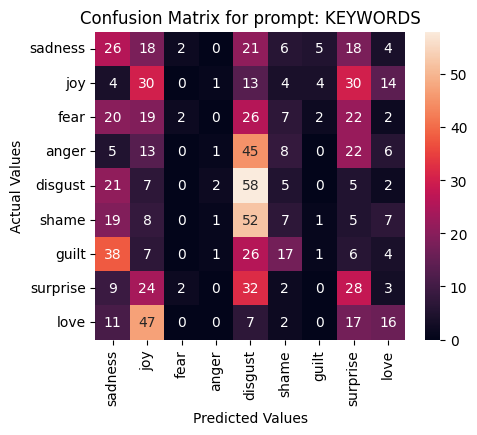

In [75]:
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "TEXT_IS_ABOUT")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "CLASS_NAME")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "THIS_IS_I_FEEL")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "I_FEEL")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "KEYWORDS")


#  mpnet Model

In [56]:
mpnet_model = "sentence-transformers/all-mpnet-base-v1"
model_name = mpnet_model.replace("/", "_").replace("-", "_")
mpnet_model = SentenceTransformer(mpnet_model)

## Topics Classification Dataset

In [58]:
prompts = ["TEXT_IS_ABOUT", "CLASS_NAME", "KEYWORDS", "TOPIC_DEFINITION", "NEWS_ABOUT"]
for prompt in prompts: 
    start = time.time()
    topic_dataset_sampled[prompt] = topic_dataset_sampled["text"].progress_apply(lambda x: predict(mpnet_model, x, topic_classes, prompt))
    duration  = time.time() - start
    avg_precision, avg_recall, avg_fscore, support = precision_recall_fscore_support(topic_dataset_sampled["topic_name"].values.tolist(), topic_dataset_sampled[prompt].values.tolist(), average='macro')
    # To check 
    per_class_percision, per_class_recall, per_class_fscore, per_class_support = precision_recall_fscore_support(topic_dataset_sampled["topic_name"].values.tolist(), topic_dataset_sampled[prompt].values.tolist(), average= None)
    with open(f"{model_name}_topic_dataset_sampled_results.json", "a") as fp:
        json.dump({
            "running time": duration,
            "prompt_type": prompt,
            "avg_precision": avg_precision,
            "avg_recall": avg_recall,
            "avg_fscore": avg_fscore,
            "per_class_percision": per_class_percision.tolist(),
            "per_class_recall": per_class_recall.tolist(),
            "per_class_fscore": per_class_fscore.tolist(),
        }, fp)

    

100%|██████████| 1000/1000 [08:29<00:00,  1.96it/s]


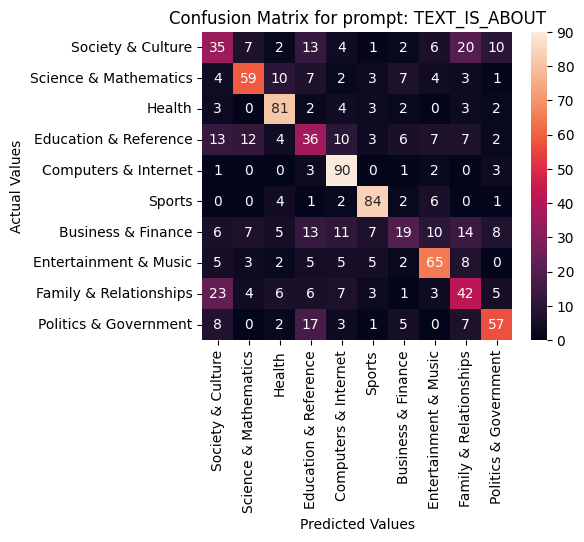

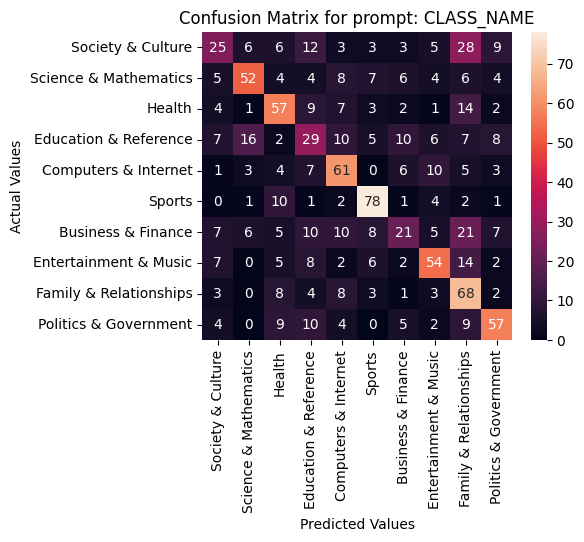

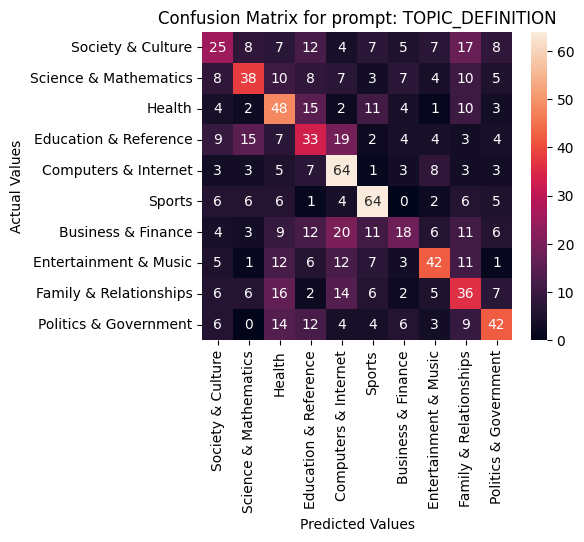

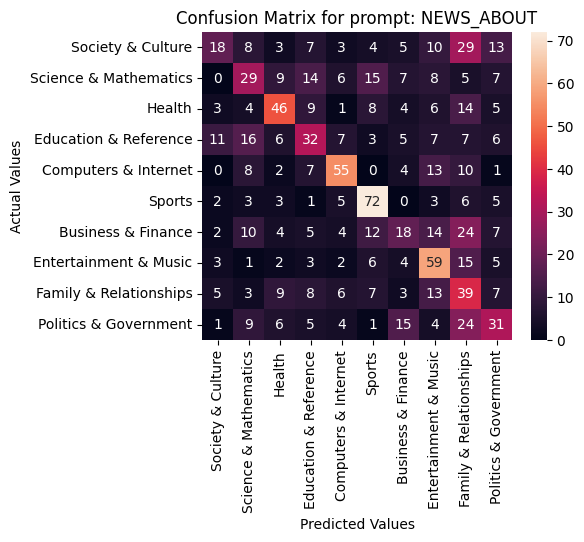

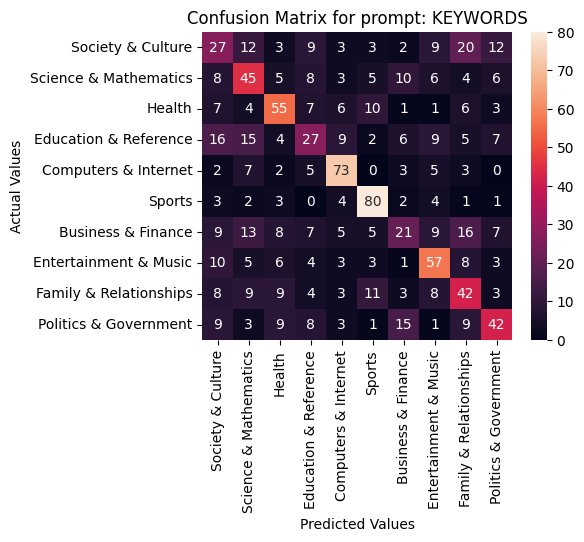

In [59]:
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "TEXT_IS_ABOUT")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "CLASS_NAME")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "TOPIC_DEFINITION")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "NEWS_ABOUT")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "KEYWORDS")

In [60]:
topic_dataset_sampled.to_csv(f"{model_name}topic_dataset_sampled_results.csv", index= False)

## Sentiment Analysis Dataset

In [19]:
prompts = ["TEXT_IS_ABOUT", "CLASS_NAME", "THIS_IS_I_FEEL", "I_FEEL", "KEYWORDS"]
labels =list(emotion_dataset_sampled["sentiment"].unique())
for prompt in prompts: 
    start = time.time()
    emotion_dataset_sampled[prompt] = emotion_dataset_sampled["text"].progress_apply(lambda x: predict(mpnet_model, x,labels, prompt))
    duration  = time.time() - start
    avg_precision, avg_recall, avg_fscore, support = precision_recall_fscore_support(emotion_dataset_sampled["sentiment"].values.tolist(), emotion_dataset_sampled[prompt].values.tolist(), average='macro')
    # To check 
    per_class_percision, per_class_recall, per_class_fscore, per_class_support = precision_recall_fscore_support(emotion_dataset_sampled["sentiment"].values.tolist(), emotion_dataset_sampled[prompt].values.tolist(), average= None)
    with open(f"{model_name}_emotion_dataset_sampled_results.json", "a") as fp:
        json.dump({
            "running time": duration,
            "prompt_type": prompt,
            "avg_precision": avg_precision,
            "avg_recall": avg_recall,
            "avg_fscore": avg_fscore,
            "per_class_percision": per_class_percision.tolist(),
            "per_class_recall": per_class_recall.tolist(),
            "per_class_fscore": per_class_fscore.tolist(),
        }, fp)

100%|██████████| 900/900 [06:25<00:00,  2.34it/s]


In [20]:
emotion_dataset_sampled.to_csv(f"{model_name}_emotion_dataset_sampled.csv", index= False)

In [70]:
emotion_dataset_sampled = pd.read_csv("sentence_transformers_all_mpnet_base_v1_emotion_dataset_sampled.csv")

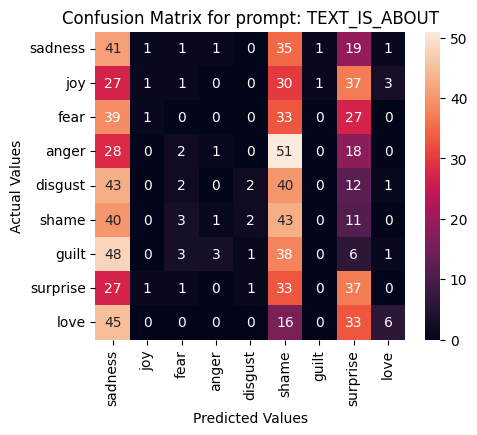

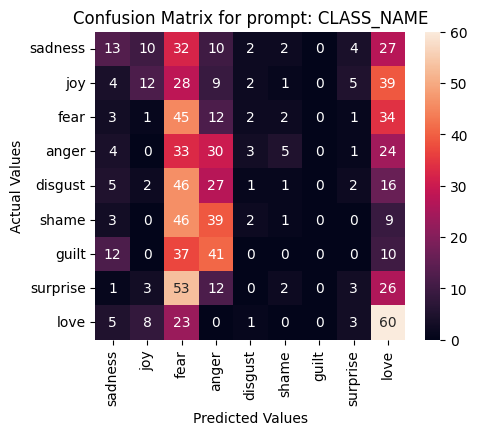

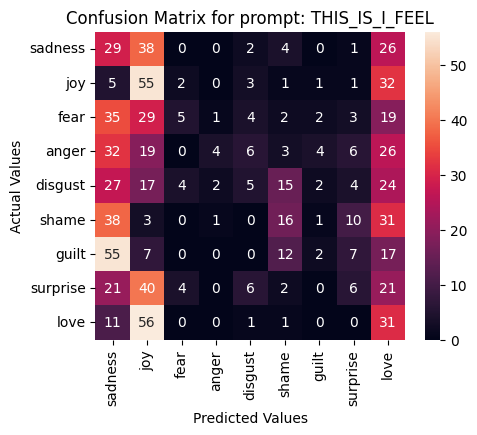

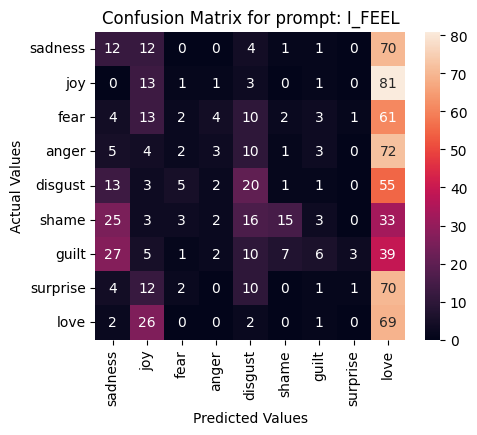

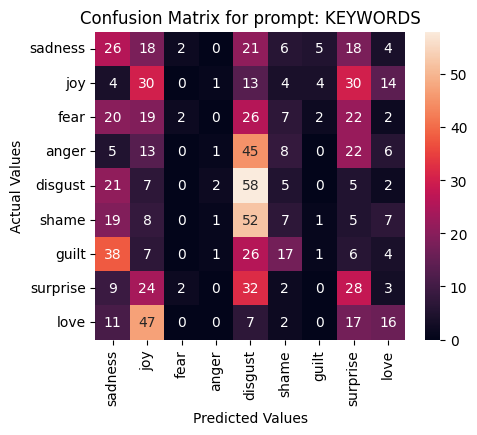

In [76]:
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "TEXT_IS_ABOUT")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "CLASS_NAME")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "THIS_IS_I_FEEL")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "I_FEEL")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "KEYWORDS")


#  T-5 base sentence Model

In [61]:
t5_base = "sentence-transformers/sentence-t5-base"
model_name = t5_base.replace("/", "_").replace("-", "_")
t5_base_model = SentenceTransformer(t5_base)

## Topics Classification Dataset

In [62]:
prompts = ["TEXT_IS_ABOUT", "CLASS_NAME", "KEYWORDS", "TOPIC_DEFINITION", "NEWS_ABOUT"]
for prompt in prompts: 
    start = time.time()
    topic_dataset_sampled[prompt] = topic_dataset_sampled["text"].progress_apply(lambda x: predict(t5_base_model, x, topic_classes, prompt))
    duration  = time.time() - start
    avg_precision, avg_recall, avg_fscore, support = precision_recall_fscore_support(topic_dataset_sampled["topic_name"].values.tolist(), topic_dataset_sampled[prompt].values.tolist(), average='macro')
    # To check 
    per_class_percision, per_class_recall, per_class_fscore, per_class_support = precision_recall_fscore_support(topic_dataset_sampled["topic_name"].values.tolist(), topic_dataset_sampled[prompt].values.tolist(), average= None)
    with open(f"{model_name}_topic_dataset_sampled_results.json", "a") as fp:
        json.dump({
            "running time": duration,
            "prompt_type": prompt,
            "avg_precision": avg_precision,
            "avg_recall": avg_recall,
            "avg_fscore": avg_fscore,
            "per_class_percision": per_class_percision.tolist(),
            "per_class_recall": per_class_recall.tolist(),
            "per_class_fscore": per_class_fscore.tolist(),
        }, fp)

    

100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]


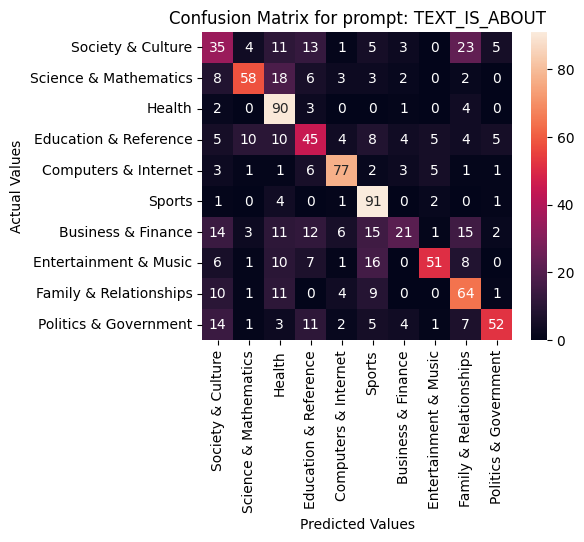

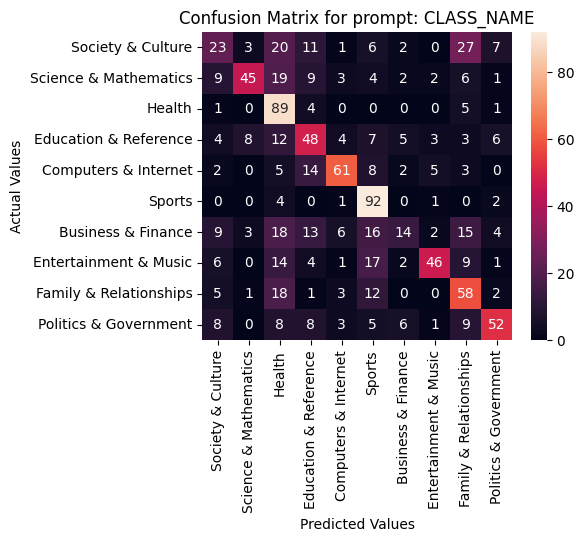

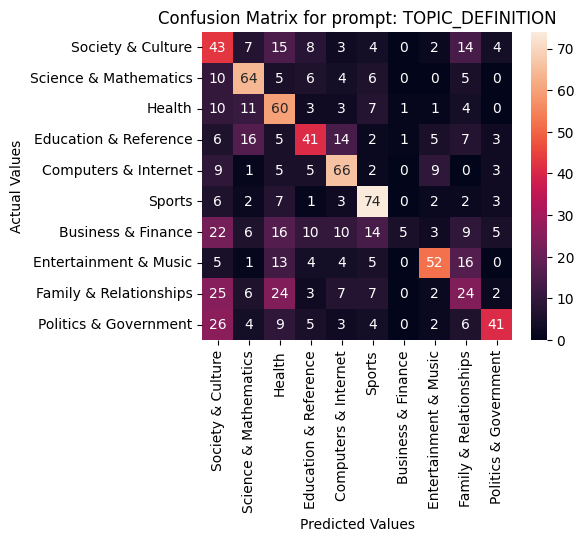

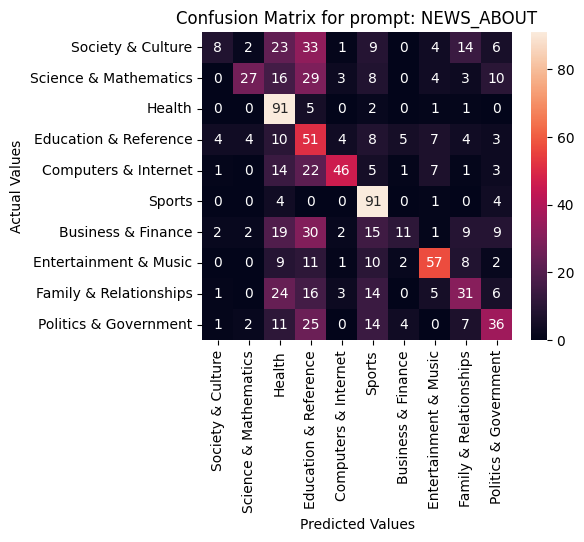

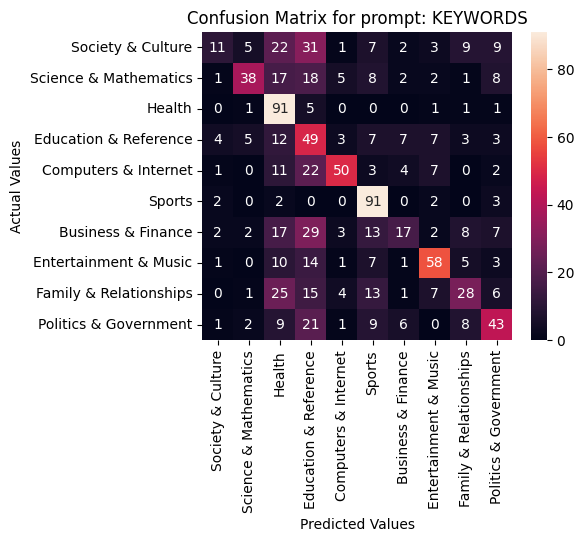

In [63]:
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "TEXT_IS_ABOUT")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "CLASS_NAME")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "TOPIC_DEFINITION")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "NEWS_ABOUT")
get_confusion_matrix(topic_dataset_sampled, topic_classes,  "topic_name", "KEYWORDS")

In [64]:
topic_dataset_sampled.to_csv(f"{model_name}_topic_dataset_sampled_results.csv", index= False)

## Sentiment Analysis Dataset

In [66]:
prompts = ["TEXT_IS_ABOUT", "CLASS_NAME", "THIS_IS_I_FEEL", "I_FEEL", "KEYWORDS"]
labels =list(emotion_dataset_sampled["sentiment"].unique())
for prompt in prompts: 
    start = time.time()
    emotion_dataset_sampled[prompt] = emotion_dataset_sampled["text"].progress_apply(lambda x: predict(t5_base_model, x,labels, prompt))
    duration  = time.time() - start
    avg_precision, avg_recall, avg_fscore, support = precision_recall_fscore_support(emotion_dataset_sampled["sentiment"].values.tolist(), emotion_dataset_sampled[prompt].values.tolist(), average='macro')
    # To check 
    per_class_percision, per_class_recall, per_class_fscore, per_class_support = precision_recall_fscore_support(emotion_dataset_sampled["sentiment"].values.tolist(), emotion_dataset_sampled[prompt].values.tolist(), average= None)
    with open(f"{model_name}_emotion_dataset_sampled_results.json", "a") as fp:
        json.dump({
            "running time": duration,
            "prompt_type": prompt,
            "avg_precision": avg_precision,
            "avg_recall": avg_recall,
            "avg_fscore": avg_fscore,
            "per_class_percision": per_class_percision.tolist(),
            "per_class_recall": per_class_recall.tolist(),
            "per_class_fscore": per_class_fscore.tolist(),
        }, fp)

100%|██████████| 900/900 [04:44<00:00,  3.16it/s]


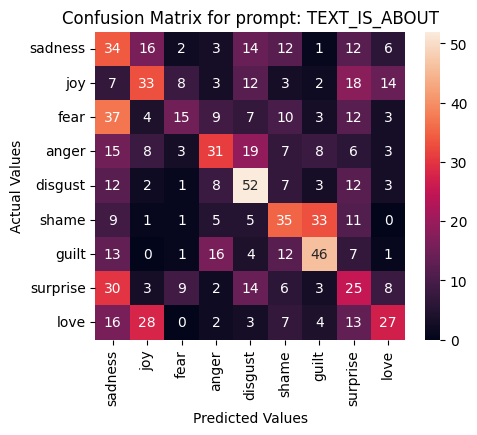

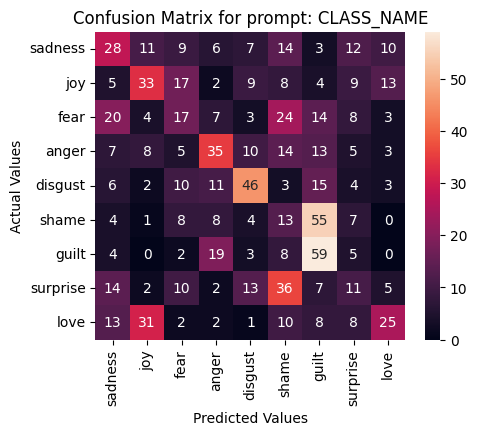

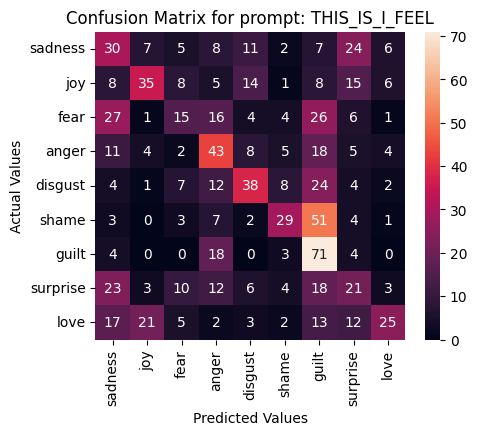

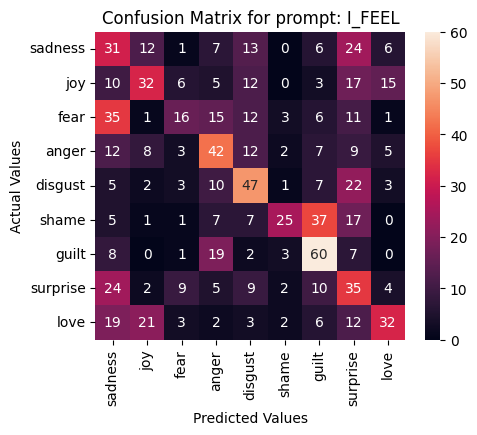

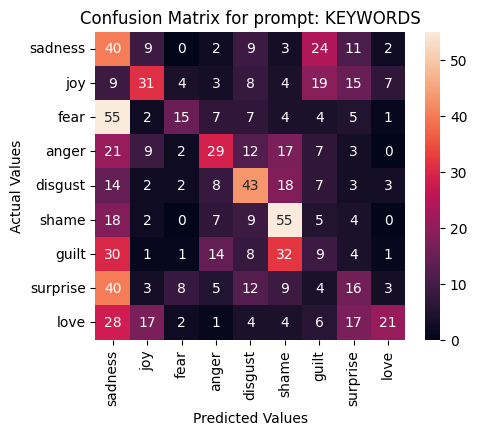

In [67]:
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "TEXT_IS_ABOUT")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "CLASS_NAME")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "THIS_IS_I_FEEL")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "I_FEEL")
get_confusion_matrix(emotion_dataset_sampled, emotion_labels,  "sentiment", "KEYWORDS")


In [69]:
emotion_dataset_sampled.to_csv(f"{model_name}_emotion_dataset_sampled.csv", index= False)